# 2022-01-19 Conditioning

* More on floating point
* Discuss Taylor Series activity
* Condition numbers
* Forward and backward error
* Computing volume of a polygon

In [2]:
using Plots
default(linewidth=4)

# Floating point representation is **relative**

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a9/IEEE_754_Double_Floating_Point_Format.svg" width="80%" />

Let $\operatorname{fl}$ round to the nearest floating point number.

$$ \operatorname{fl}(x) = x (1 + \epsilon), \quad \text{where} |\epsilon| \le \epsilon_{\text{machine}} $$

This also means that the relative error in representing $x$ is small:

$$ \frac{|\operatorname{fl}(x) - x|}{|x|} \le \epsilon_{\text{machine}} $$

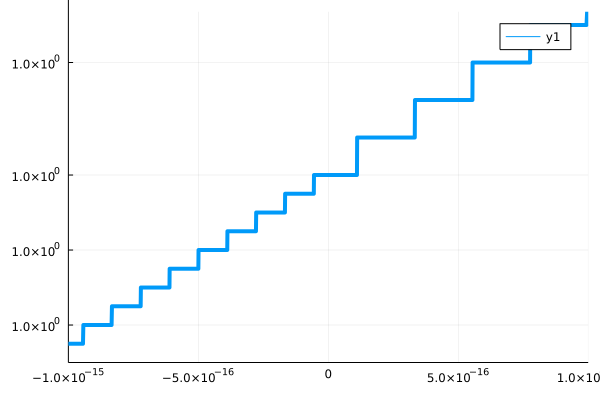

GKS: Possible loss of precision in routine SET_WINDOW


In [63]:
plot(x -> (1 + x), xlims=(-1e-15, 1e-15))
#plot!(x -> x)

# Exact arithmetic, correctly rounded

Take an elementary math operation $*$ (addition, subtraction, multiplication, division), and the discrete operation that our computers perform, $\circledast$. Then

$$x \circledast y := \operatorname{fl}(x * y)$$

with a relative accuracy $\epsilon_{\text{machine}}$,

$$ \frac{|(x \circledast y) - (x * y)|}{|x * y|} \le \epsilon_{\text{machine}} . $$

## Seems easy, how do operations compose?

Is this true?

$$ \frac{\Big\lvert \big((x \circledast y) \circledast z\big) - \big((x * y) * z\big) \Big\rvert}{|(x * y) * z|} \le^? \epsilon_{\text{machine}} $$

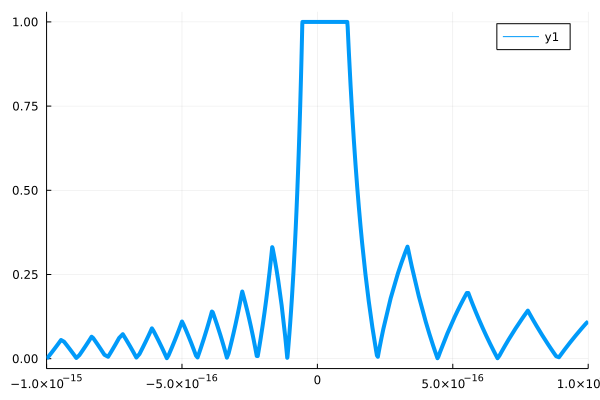

In [10]:
f(x; y=1, z=-1) = (x+y)+z # The best arbitrary numbers are 0, 1, and -1
plot(x -> abs(f(x) - x)/abs(x), xlims=(-1e-15, 1e-15))

# Which operation caused the error?

1. $\texttt{tmp} = \operatorname{fl}(x + 1)$
2. $\operatorname{fl}(\texttt{tmp} - 1)$

Use Julia's [`BigFloat`](https://docs.julialang.org/en/v1/base/numbers/#BigFloats-and-BigInts)

In [28]:
@show typeof(big(.1))
@show big(.1)          # Or BigFloat(.1); parsed as Float64, then promoted
@show BigFloat(".1");  # Parse directly to BigFloat

typeof(big(0.1)) = BigFloat
big(0.1) = 0.1000000000000000055511151231257827021181583404541015625
BigFloat(".1") = 0.1000000000000000000000000000000000000000000000000000000000000000000000000000002


In [27]:
tmp = 1e-15 + 1
tmp_big = big(1e-15) + 1 # Parse as Float64, then promote
abs(tmp - tmp_big) / abs(tmp_big)

1.102230246251563524952071662733800140614440125894379682676737388538642032894338e-16

In [12]:
r = tmp - 1
r_big = big(tmp) - 1
abs(r - r_big) / abs(r_big)

0.0

# Activity: [2022-01-12-taylor-series](https://classroom.github.com/a/VkPvGOgu)

* Use Julia, Jupyter, Git
* Look at how fast series converge when taking only finitely many terms
* Explore instability, as is occuring for large negative `x` above, but not for the standard library `expm1`

In [36]:
function myexp(x, k)
    sum = 0
    term = 1
    n = 1
    # modify so at most k terms are summed
    while sum + term != sum
        sum += term
        term *= x / n
        # YOUR CODE HERE
        if n == k
            break
        end
        n += 1
    end
    sum
end

rel_error(x, k) = abs(myexp(x, k) - exp(x)) / exp(x)
ks = 2 .^ (0:10)  # [1, 2, 4, ..., 1024];

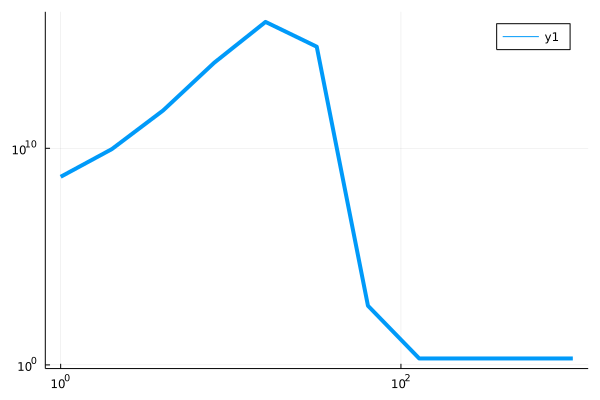

In [37]:
plot(ks, k -> rel_error(-20, k), xscale=:log10, yscale=:log10)

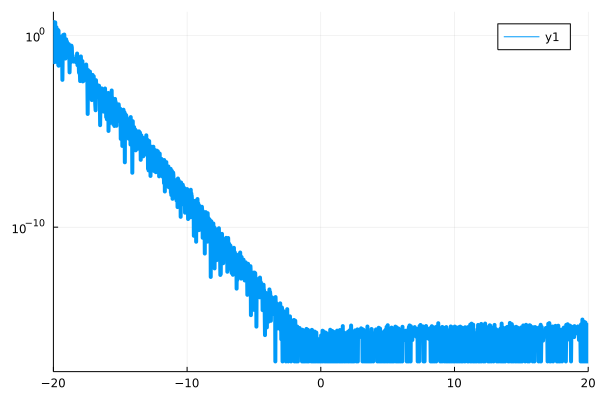

In [39]:
plot(x -> rel_error(x, 1000) + 1e-17, xlims=(-20, 20), yscale=:log10)

# What happened?
Let's look at the terms for positive and negative $x$

In [59]:
function expterms(x, k=20)
    term = 1.
    terms = [term]
    for n in 1:k
        term *= x / n
        push!(terms, term)
    end
    terms
end
x = 5
@show sum(expterms(x)) - exp(x)
expterms(x)

sum(expterms(x)) - exp(x) = -1.2035194743020838e-5


21-element Vector{Float64}:
  1.0
  5.0
 12.5
 20.833333333333336
 26.04166666666667
 26.04166666666667
 21.701388888888893
 15.500992063492067
  9.688120039682541
  5.382288910934745
  2.6911444554673727
  1.2232474797578967
  0.5096864498991237
  0.19603324996120144
  0.07001187498614338
  0.02333729166204779
  0.0072929036443899345
  0.0021449716601146867
  0.0005958254611429686
  0.0001567961739849917
  3.9199043496247926e-5

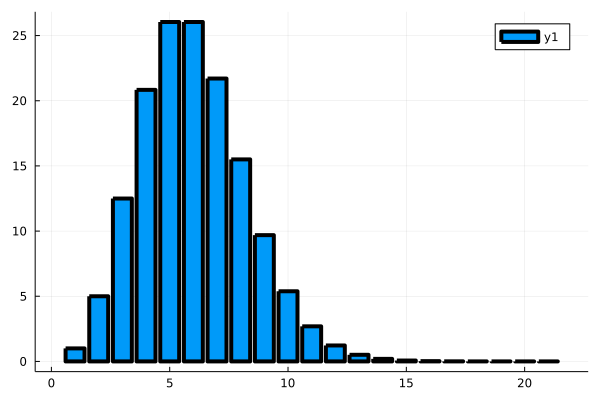

In [60]:
bar(expterms(5))

# Conditioning

> What sort of functions cause small errors to become big?

Consider a function $f: X \to Y$ and define the **absolute condition number**
$$ \hat\kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\hat\kappa = |f'(x)|$.

Floating point offers relative accuracy, so it's more useful to discuss **relative condition number**,
$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}
= \max_{\delta x} \Big[ \frac{|\delta f|/|\delta x|}{|f| / |x|} \Big] $$
or, if $f$ is differentiable,
$$ \kappa = |f'(x)| \frac{|x|}{|f|} . $$

# Condition numbers

> $$ \kappa = |f'(x)| \frac{|x|}{|f|} $$

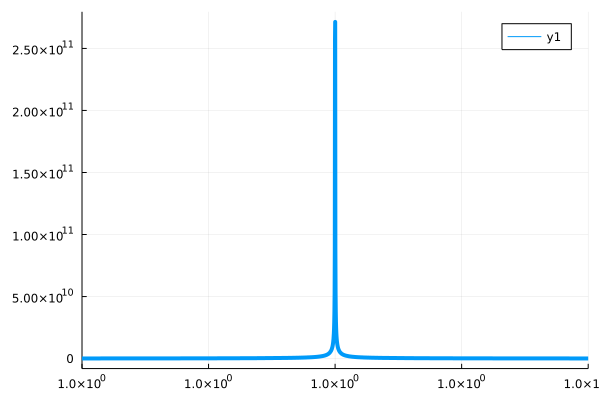

In [61]:
f(x) = x - 1; fp(x) = 1
plot(x -> abs(fp(x)) * abs(x) / abs(f(x)), xlims=(1-1e-8, 1+1e-8))

# Back to $f(x) = e^x - 1$

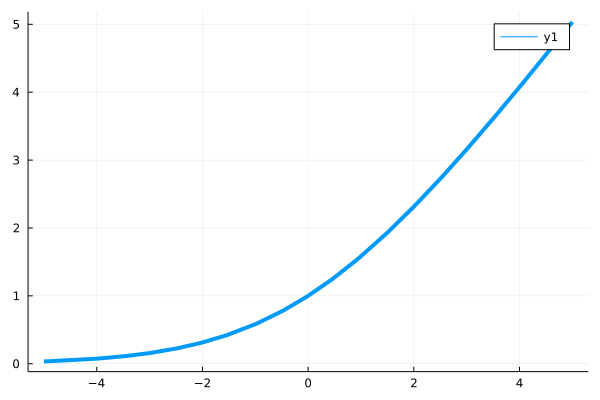

In [65]:
f(x) = exp(x) - 1
fp(x) = exp(x)
plot(x -> abs(fp(x)) * abs(x) / abs(f(x)))

## What does it mean?

* The function $f(x) = e^x - 1$ is well-conditioned
* The function $f_1(x) = e^x$ is well-conditioned
* The function $f_2(x) = x - 1$ is ill-conditioned for $x \approx 1$

## The **algorithm** is unstable

* `f(x) = exp(x) - 1` is unstable
* Algorithms are made from elementary operations
* Unstable algorithms do something ill-conditioned

# A stable algorithm

We used the series expansion previously.
* accurate for small $x$
* less accurate for negative $x$ (see activity)
* we could use symmetry to fix
* inefficient because we have to sum lots of terms

Standard math libraries define a more efficient stable variant, $\texttt{expm1}(x) = e^x - 1$.

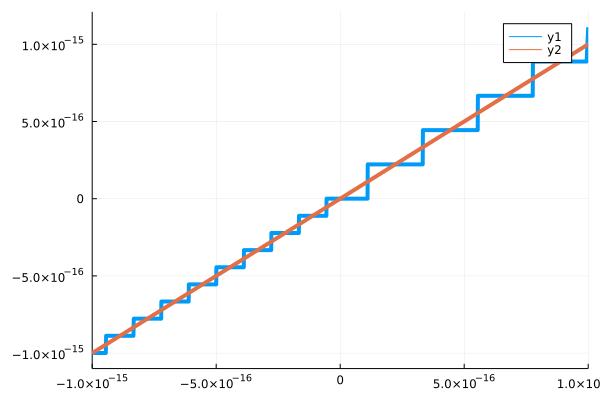

In [67]:
plot([x -> exp(x) - 1,
      x -> expm1(x)],
    xlims = (-1e-15, 1e-15))

# Another example $\log(1 + x)$

What is the condition number of $f(x) = \log(1 + x)$ for $x \approx 0$?

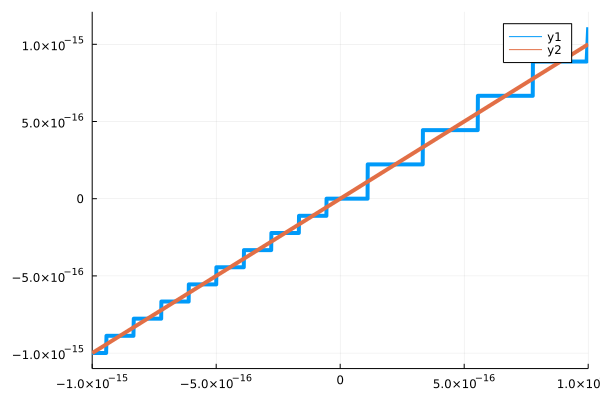

In [68]:
plot([x -> log(1 + x),
      x -> log1p(x)],
    xlims = (-1e-15, 1e-15))

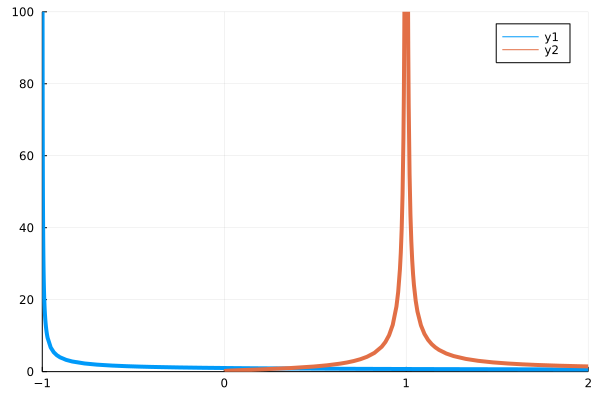

In [77]:
cond1(x) = abs(1/(1+x) * x / log1p(x))
cond2(x) = abs(1/x * x / log(x))
plot([cond1 cond2], xlims=(-1, 2), ylims=(0, 100))

# Reliable = well-conditioned and stable

## Mathematical functions $f(x)$ can be ill-conditioned (big $\kappa$)
* Modeling is how we turn an abstract question into a mathematical function
* We want well-conditioned models (small $\kappa$)
* Some systems are intrinsically sensitive: fracture, chaotic systems, combustion

## Algorithms `f(x)` can be unstable
* Unreliable, though sometimes practical
* Unstable algorithms are constructed from ill-conditioned parts

# An ill-conditioned problem from Paul Olum

From [Surely You're Joking, Mr. Feynman](https://sistemas.fciencias.unam.mx/%7Ecompcuantica/RICHARD%20P.%20FEYNMAN-SURELY%20YOU%27RE%20JOKING%20MR.%20FEYNMAN.PDF) (page 113)

> So Paul is walking past the lunch place and these guys are all excited. "Hey, 
Paul!" they call out. "Feynman's terrific! We give him a problem that can be stated in ten 
seconds, and in a minute he gets the answer to 10 percent. Why don't you give him one?" 
Without hardly stopping, he says, "The tangent of 10 to the 100th." 
I was sunk: you have to divide by pi to 100 decimal places! It was hopeless.

What's the condition number?

$$ \kappa = |f'(x)| \frac{|x|}{|f|} $$

* $f(x) = \tan x$
* $f'(x) = 1 + \tan^2 x$

$$ \kappa = \lvert x \rvert \Bigl( \lvert \tan x \rvert + \bigl\lvert \frac{1}{\tan x} \bigr\rvert \Bigr)$$

In [78]:
tan(1e100)

-0.4116229628832498

In [87]:
tan(BigFloat("1e100", precision=100))

2.738770191194700792231947565702313204942361296608129856300353713193607246577622

# Go find some functions...

* Find a function $f(x)$ that models something you're interested in
* Plot its condition number $\kappa$ as a function of $x$
* Plot the relative error (using single or double precision; compare using Julia's `big`)
* Is the relative error ever much bigger than $\kappa \epsilon_{\text{machine}}$?
* Can you find what caused the instability?
* Share on Zulip

## Further reading: [FNC Introduction](https://fncbook.github.io/fnc/intro/overview.html)